In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error

In [2]:
# df_n = pd.read_csv("C:/Users/sakif/jupyter projects/thesis_test/modular test/ped_group_data_1000.csv", index_col=None)

df_n = pd.read_csv("C:/Users/sakif/jupyter projects/thesis_test/modular test/ped_group_data_final_1000_group_fixed.csv",
                   index_col=None)

In [3]:
df_n.head()

,ped1_x,ped1_y,d_w1,d_w2,d_w3,d_w4,d_w5,d_w6,d_w7,d_w8,...,repulse_bound_x,repulse_bound_y,total_x,total_y,group_x,group_y,centroid_dist,rotation_angle,eta_group_x,eta_group_y
0,3.151296,0.812570,7.518455,7.539853,1.824990,0.0,0.0,0.0,0.0,0.0,...,0.000205,5.159880e-07,-0.179403,0.578560,0.0,0.0,0.0,0.0,0.0,0.0
1,3.316522,0.924126,7.518455,0.227481,8.727315,0.0,0.0,0.0,0.0,0.0,...,-0.000398,4.620207e-06,-0.037931,0.118670,0.0,0.0,0.0,0.0,0.0,0.0
2,3.480186,1.039624,7.539853,0.227481,8.785952,0.0,0.0,0.0,0.0,0.0,...,-0.000909,-1.638707e-06,-0.009764,0.024631,0.0,0.0,0.0,0.0,0.0,0.0
3,3.643004,1.155970,1.824990,8.727315,8.785952,0.0,0.0,0.0,0.0,0.0,...,-0.002058,-3.182115e-05,-0.005290,0.005300,0.0,0.0,0.0,0.0,0.0,0.0
4,3.805033,1.272525,7.070194,7.243578,1.924727,0.0,0.0,0.0,0.0,0.0,...,-0.004651,3.400722e-05,-0.004931,0.001306,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_n.columns

Index(['ped1_x', 'ped1_y', 'd_w1', 'd_w2', 'd_w3', 'd_w4', 'd_w5', 'd_w6',
       'd_w7', 'd_w8', 'd_w9', 'n_w_x1', 'n_w_y1', 'n_w_x2', 'n_w_y2',
       'n_w_x3', 'n_w_y3', 'n_w_x4', 'n_w_y4', 'n_w_x5', 'n_w_y5', 'n_w_x6',
       'n_w_y6', 'n_w_x7', 'n_w_y7', 'n_w_x8', 'n_w_y8', 'n_w_x9', 'n_w_y9',
       'n_w_bound_x', 'n_w_bound_y', 'd_w_bound', 'goal_x', 'goal_y',
       'bound_x', 'bound_y', 'n1_x', 'n1_y', 'n2_x', 'n2_y', 'n3_x', 'n3_y',
       'n4_x', 'n4_y', 'n5_x', 'n5_y', 'n6_x', 'n6_y', 'n7_x', 'n7_y', 'n8_x',
       'n8_y', 'n9_x', 'n9_y', 'n1_repulse_x', 'n1_repulse_y', 'n2_repulse_x',
       'n2_repulse_y', 'n3_repulse_x', 'n3_repulse_y', 'n4_repulse_x',
       'n4_repulse_y', 'n5_repulse_x', 'n5_repulse_y', 'n6_repulse_x',
       'n6_repulse_y', 'n7_repulse_x', 'n7_repulse_y', 'n8_repulse_x',
       'n8_repulse_y', 'n9_repulse_x', 'n9_repulse_y', 'attract_x',
       'attract_y', 'repulse_total_x', 'repulse_total_y', 'repulse_bound_x',
       'repulse_bound_y', 'total_x', 

In [5]:
df_n.columns[-26:-24]

Index(['n4_repulse_x', 'n4_repulse_y'], dtype='object')

In [6]:
temp_input = df_n.values[:, :2].astype('float32')

In [7]:
print(len(temp_input) - 9)
data_length = len(temp_input) - 9

1219391


In [8]:
len(df_n.columns)

86

In [9]:
# dataset definition
# return both trajectories and tw, nw
# obstacle -6:-4
# neighbour 1: -24:-22
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path, data_length2):
        # load the csv file as a dataframe
        df = pd.read_csv(path, index_col=None)
        # print(df.head())
        # process input and outputs
        temp_input = df.values[:, :2].astype('float32')
        # type 2: 0:10, then 1:11 and so on
        temp_input2 = []
        # print(len(temp_input)-10)
        for x in range(0, data_length2, 1):
            # print(x)
            # print(temp_input[x:(10+x)] - temp_input[x])
            temp_input3 = temp_input[x:(10+x)] - temp_input[x]
            for z in range(len(temp_input3)):
                temp_input2.append(temp_input3[z])
        temp_input2 = np.array(temp_input2)
        temp_input2 = temp_input2.reshape(data_length2, 20)
        
        # appending dw, e, and n_w
        
        temp_e_x = np.reshape(np.array(df["goal_x"][9:], dtype='float32'), (data_length2, 1))
        temp_e_y = np.reshape(np.array(df["goal_y"][9:], dtype='float32'), (data_length2, 1))
        
        temp_dw4 = np.exp(np.reshape(np.array(df["d_w4"][9:], dtype='float32'), (data_length2, 1)))
        temp_nw_x4 = np.reshape(np.array(df["n_w_x4"][9:], dtype='float32'), (data_length2, 1))
        temp_nw_y4 = np.reshape(np.array(df["n_w_y4"][9:], dtype='float32'), (data_length2, 1))
        
        temp_input2 = np.concatenate((temp_input2, temp_e_x), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_e_y), axis=1)
        
        temp_input2 = np.concatenate((temp_input2, temp_dw4), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_x4), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_y4), axis=1)
        # 0:20 trajectories, 20:22 goal, 22: dw, nw 
        
        # temp_e_x[temp_e_x == 0.0] = 10
        # temp_e_y[temp_e_y == 0.0] = 10
        
        
        # print(temp_e_y)
        """
        
        temp_dw1 = np.exp(np.reshape(np.array(df["d_w1"][9:], dtype='float32'), (data_length2, 1)))
        temp_nw_x1 = np.reshape(np.array(df["n_w_x1"][9:], dtype='float32'), (data_length2, 1))
        temp_nw_y1 = np.reshape(np.array(df["n_w_y1"][9:], dtype='float32'), (data_length2, 1))
        
        temp_dw2 = np.exp(np.reshape(np.array(df["d_w2"][9:], dtype='float32'), (data_length2, 1)))
        temp_nw_x2 = np.reshape(np.array(df["n_w_x2"][9:], dtype='float32'), (data_length2, 1))
        temp_nw_y2 = np.reshape(np.array(df["n_w_y2"][9:], dtype='float32'), (data_length2, 1))
        
        temp_dw3 = np.exp(np.reshape(np.array(df["d_w3"][9:], dtype='float32'), (data_length2, 1)))
        temp_nw_x3 = np.reshape(np.array(df["n_w_x3"][9:], dtype='float32'), (data_length2, 1))
        temp_nw_y3 = np.reshape(np.array(df["n_w_y3"][9:], dtype='float32'), (data_length2, 1))
        
        temp_dw4 = np.exp(np.reshape(np.array(df["d_w4"][9:], dtype='float32'), (data_length2, 1)))
        temp_nw_x4 = np.reshape(np.array(df["n_w_x4"][9:], dtype='float32'), (data_length2, 1))
        temp_nw_y4 = np.reshape(np.array(df["n_w_y4"][9:], dtype='float32'), (data_length2, 1))
        
        temp_dw5 = np.exp(np.reshape(np.array(df["d_w5"][9:], dtype='float32'), (data_length2, 1)))
        temp_nw_x5 = np.reshape(np.array(df["n_w_x5"][9:], dtype='float32'), (data_length2, 1))
        temp_nw_y5 = np.reshape(np.array(df["n_w_y5"][9:], dtype='float32'), (data_length2, 1))
        
        temp_dw6 = np.exp(np.reshape(np.array(df["d_w6"][9:], dtype='float32'), (data_length2, 1)))
        temp_nw_x6 = np.reshape(np.array(df["n_w_x6"][9:], dtype='float32'), (data_length2, 1))
        temp_nw_y6 = np.reshape(np.array(df["n_w_y6"][9:], dtype='float32'), (data_length2, 1))
        
        temp_dw7 = np.exp(np.reshape(np.array(df["d_w7"][9:], dtype='float32'), (data_length2, 1)))
        temp_nw_x7 = np.reshape(np.array(df["n_w_x7"][9:], dtype='float32'), (data_length2, 1))
        temp_nw_y7 = np.reshape(np.array(df["n_w_y7"][9:], dtype='float32'), (data_length2, 1))
        
        temp_dw8 = np.exp(np.reshape(np.array(df["d_w8"][9:], dtype='float32'), (data_length2, 1)))
        temp_nw_x8 = np.reshape(np.array(df["n_w_x8"][9:], dtype='float32'), (data_length2, 1))
        temp_nw_y8 = np.reshape(np.array(df["n_w_y8"][9:], dtype='float32'), (data_length2, 1))
        
        temp_dw9 = np.exp(np.reshape(np.array(df["d_w9"][9:], dtype='float32'), (data_length2, 1)))
        temp_nw_x9 = np.reshape(np.array(df["n_w_x9"][9:], dtype='float32'), (data_length2, 1))
        temp_nw_y9 = np.reshape(np.array(df["n_w_y9"][9:], dtype='float32'), (data_length2, 1))
        
        # concatinating (0, 19) == trajectories, [20, 21] == [e_x, e_y] ,[22, 23, 24] == [dw1, nw_x1, nw_y1], 
        # [25, 26, 27] == [dw2, nw_x2, nw_y2], [28, 29, 30] == [dw3, nw_x3, nw_y3]
        
        temp_input2 = np.concatenate((temp_input2, temp_e_x), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_e_y), axis=1)
        
        temp_input2 = np.concatenate((temp_input2, temp_dw1), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_x1), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_y1), axis=1)
        
        temp_input2 = np.concatenate((temp_input2, temp_dw2), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_x2), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_y2), axis=1)
        
        temp_input2 = np.concatenate((temp_input2, temp_dw3), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_x3), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_y3), axis=1)
        
        temp_input2 = np.concatenate((temp_input2, temp_dw4), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_x4), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_y4), axis=1)
        
        temp_input2 = np.concatenate((temp_input2, temp_dw5), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_x5), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_y5), axis=1)
        
        temp_input2 = np.concatenate((temp_input2, temp_dw6), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_x6), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_y6), axis=1)
        
        temp_input2 = np.concatenate((temp_input2, temp_dw7), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_x7), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_y7), axis=1)
        
        temp_input2 = np.concatenate((temp_input2, temp_dw8), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_x8), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_y8), axis=1)
        
        temp_input2 = np.concatenate((temp_input2, temp_dw9), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_x9), axis=1)
        temp_input2 = np.concatenate((temp_input2, temp_nw_y9), axis=1)
        """
        
        print(np.shape(temp_input2))
        
        temp_out = df.values[:, -26:-24].astype('float32')
        temp_out = temp_out[9:]
        
        # store the inputs and outputs 
        self.X = temp_input2
        self.y = temp_out
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 2))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.5):
        # determine sizes
        test_size_temp = round(n_test * len(self.X))
        train_size = len(self.X) - test_size_temp
        dev_size = round(.5 * test_size_temp)
        test_size = test_size_temp - dev_size
        # calculate the split
        print(train_size, dev_size, test_size)
        return data_utils.dataset.random_split(self, [train_size, dev_size, test_size])

In [10]:
# prepare the dataset
def prepare_data(path, data_length3):
    # load the dataset
    dataset = CSVDataset(path, data_length3)
    # calculate split
    train, dev, test = dataset.get_splits()
    # prepare data loaders
    train_dl = data_utils.DataLoader(train, batch_size=16, shuffle=True)
    dev_dl = data_utils.DataLoader(dev, batch_size=16, shuffle=True)
    test_dl = data_utils.DataLoader(test, batch_size=16, shuffle=False)
    return train_dl, dev_dl, test_dl

In [11]:
# Total Net1 , predicts fo, fw and then finally total f 
# concatinating (0, 19) == trajectories, [20, 21] == [e_x, e_y] ,[22] = dw1 , [23, 24] == [nw_x1, nw_y1], 
# [25] = dw2, [26, 27] == [nw_x2, nw_y2], [28] = dw3,  [29, 30] == [nw_x3, nw_y3]
# here, dw is actually e^dw

class Net3_ped4(nn.Module):
    # only attract and ped repulse here. boundary repulse can be easily added
    def __init__(self):
        super().__init__()
        
        # net2 starts // inputs: e^dw1 and [nw_x1, nw_y1], e_x and e_y
        self.fc1 = nn.Linear(3, 2)
        self.fc2 = nn.Linear(5, 2)
        self.fc3 = nn.Linear(4, 2)        

    def forward(self, e, x3):
        # x3 = (e^dw1, nw_x1, nw_y1)
        
        x3_alt_input = torch.cat((e, x3), 1)
        x3 = torch.relu(self.fc1(x3))
        # x3_alt_temp = torch.cat((e, x3))
        x3_alt = torch.relu(self.fc2(x3_alt_input))
        x3_temp = torch.cat((x3, x3_alt), 1)
        
        x = self.fc3(x3_temp)
        
        return x

In [12]:
# data_path_final = "C:/Users/sakif/jupyter projects/thesis_test/modular test/ped_group_data_1000.csv"
data_path_final = "C:/Users/sakif/jupyter projects/thesis_test/modular test/ped_group_data_final_1000_group_fixed.csv"

In [13]:
train_dl, dev_dl, test_dl = prepare_data(data_path_final, data_length)

(1219391, 25)
609695 304848 304848


In [14]:
net3_ped4 = Net3_ped4()
print(net3_ped4)

Net3_ped4(
  (fc1): Linear(in_features=3, out_features=2, bias=True)
  (fc2): Linear(in_features=5, out_features=2, bias=True)
  (fc3): Linear(in_features=4, out_features=2, bias=True)
)


In [15]:
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = torch.Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
# evaluate the model

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        # 0:20 trajectories, 20:22 goal, 22: dw, nw
        goal2 = inputs[:, 20:22]
        x3 = inputs[:, 22:]
        # x3 = inputs[:, 22:25]
        # x4 = inputs[:, 25:28]
        # x5 = inputs[:, 28:]
        yhat = model(goal2, x3)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 2))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    # mse = np.mean((actuals - predictions)**2)
    return mse

In [18]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net3_ped4.parameters(), lr=0.001)

In [19]:
loss_array = []
x_array = []
dev_loss_array = []

In [20]:
for epoch in range(10):
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_dl):
        
        # clear the gradients
        optimizer.zero_grad()
        # concatinating (0, 19) == trajectories, [20, 21] == [e_x, e_y] ,[22] = dw1 , [23, 24] == [nw_x1, nw_y1], 
        # [25] = dw2, [26, 27] == [nw_x2, nw_y2], [28] = dw3,  [29, 30] == [nw_x3, nw_y3]
        # 0:20 trajectories, 20:22 goal, 22: dw, nw
        goal2 = inputs[:, 20:22]
        x3 = inputs[:, 22:]
        # goal2 = torch.Tensor(goal2)
        # x1, goal = speed_finder(inputs)
        yhat = net3_ped4(goal2, x3)
        # calculate loss
        loss = loss_function(yhat, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
    print("epoch no: ", epoch)
    print(loss.item())
    loss_array.append(loss.item())
    x_array.append(epoch)
    
    # evaluate dev
    mse = evaluate_model(dev_dl, net3_ped4)
    dev_loss_array.append(mse)
    print('MSE_dev: %.8f, RMSE: %.4f' % (mse, np.sqrt(mse)))

epoch no:  0
0.0005803406820632517
MSE_dev: 0.01269870, RMSE: 0.1127
epoch no:  1
3.724656562553719e-05
MSE_dev: 0.01268953, RMSE: 0.1126
epoch no:  2
0.03664352744817734
MSE_dev: 0.01268946, RMSE: 0.1126
epoch no:  3
0.00594226224347949
MSE_dev: 0.01272989, RMSE: 0.1128
epoch no:  4
0.0003523609775584191
MSE_dev: 0.01270203, RMSE: 0.1127
epoch no:  5
0.01331313606351614
MSE_dev: 0.01271200, RMSE: 0.1127
epoch no:  6
0.019658200442790985
MSE_dev: 0.01270396, RMSE: 0.1127
epoch no:  7
0.0004299570282455534
MSE_dev: 0.01271947, RMSE: 0.1128
epoch no:  8
0.023958683013916016
MSE_dev: 0.01270306, RMSE: 0.1127
epoch no:  9
0.00866248644888401
MSE_dev: 0.01269744, RMSE: 0.1127


In [21]:
from matplotlib import pyplot as plt

In [22]:
mse = evaluate_model(test_dl, net3_ped4)
print('MSE_dev: %.16f, RMSE: %.4f' % (mse, np.sqrt(mse)))

MSE_dev: 0.0125311594456434, RMSE: 0.1119


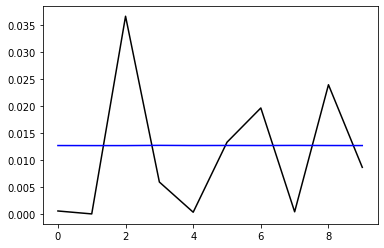

In [23]:
# 10 hidden layers
plt.plot(x_array, loss_array, color="black")
plt.plot(x_array, dev_loss_array, color="blue")
plt.show()

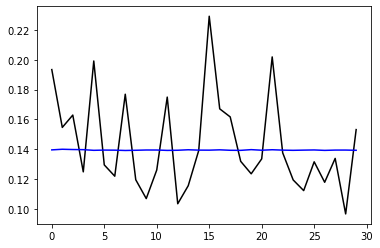

In [53]:
# 20 hidden layers
plt.plot(x_array, loss_array, color="black")
plt.plot(x_array, dev_loss_array, color="blue")
plt.show()

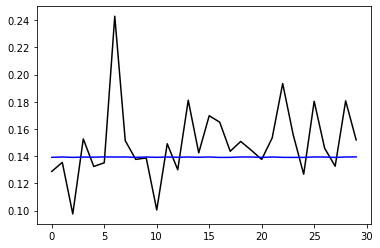

In [68]:
# 50 hidden layers
plt.plot(x_array, loss_array, color="black")
plt.plot(x_array, dev_loss_array, color="blue")
plt.show()

In [24]:
# epoch: 10
# loss: 0.00013872241834178567
torch.save(net3_ped4.state_dict(), "C:/Users/sakif/jupyter projects/thesis_test/modular test/weights/net3_ped4.pth")